## 数据增广
- 很有必要，比如色温，亮度等的变化是很容易产生的，但是模型本身不应该对这些因素非常敏感
- 增加一个已有数据集，使得具有更多的多样性
- 数据增广一般是`在线生成`， 就是数据集读进去之后再数据增广
- 增广在有些情况下是为了去逼近测试集

- 高斯滤波分为高通滤波和低通滤波，高通滤波主要作用是锐化， 低通滤波主要作用是平滑

### 方法
1. 反转
   1. 上下翻转
   2. 左右翻转
2. 切割
   1. 切割出一块然后再变成固定形状
   2. 随机高宽比(e.g.[3/4, 4/3])
   3. 随机大小(e.g.[8%, 100%])
   4. 随机位置
3. 颜色
   1. 色调
   2. 饱和度
   3. 明亮度(e.g.[0.5, 1.5])

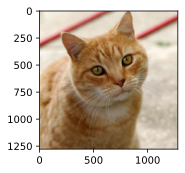

In [10]:
%matplotlib inline
import torch
import torchvision
from d2l import torch as d2l
from torch import nn
import torchvision.transforms as T

d2l.set_figsize()
img = d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img)

- 此函数在输入图像img上多次运行图像增广方法aug并显示所有结果

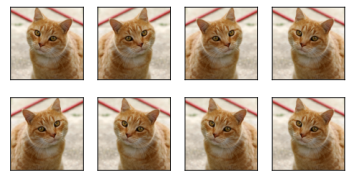

In [11]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

apply(img, T.RandomHorizontalFlip())

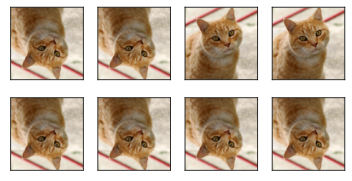

In [12]:
apply(img, T.RandomVerticalFlip())

- 我们可以通过裁剪降低模型对于图像中物体位置的敏感性

下面的代码将随机裁剪一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5～2之间随机取值。 然后，区域的宽度和高度都被缩放到200像素。

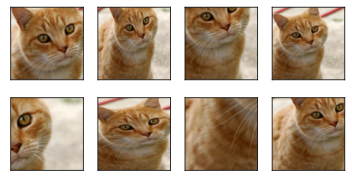

In [13]:
shaped_aug = T.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shaped_aug)

- 我们可以改变图像颜色的四个方面：  
    - 亮度
    - 对比度
    - 饱和度
    - 色调

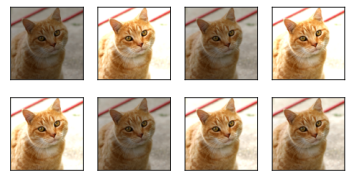

In [14]:
# 只改变亮度到原来的（0.5， 1.5）
apply(img, T.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

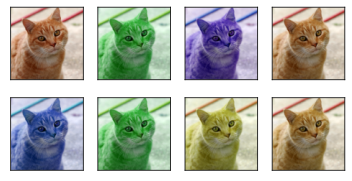

In [15]:
# 只改变色调
apply(img, T.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

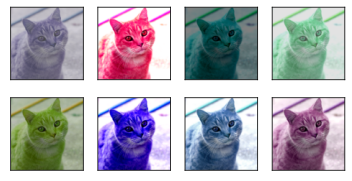

In [16]:
color_aug = T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

- 结合多种图像增广的方法

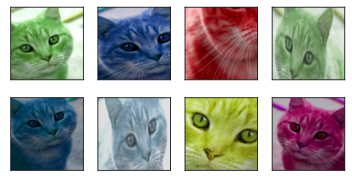

In [17]:
augs = T.Compose([
    T.RandomHorizontalFlip(), shaped_aug, color_aug
])
apply(img, augs)

- 使用图像增广进行训练

100.0%


Extracting ../data\cifar-10-python.tar.gz to ../data


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

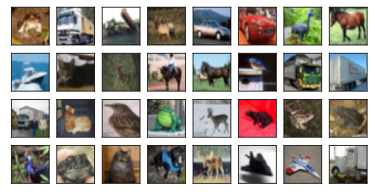

In [18]:
all_images = torchvision.datasets.CIFAR10(root='../data', train=True, download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)